# 3. Feature Extraction, Transformations and Load: 

     En este notebook vamos a recoger los datos de su origen, a darles formato, analizarlos y limpiarlos para poder utilizarlos en nuestros modelos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline
matplotlib.style.use("ggplot")

In [2]:
pd.set_option('display.max_columns', None)

## 3.1. Data Quality: nans, wrong data, etc.

### 1. File loading and examine:

     Vamos a utilizar los data sets desde el 2000 hasta el 2016. Creamos un algoritmo que sea capaz de cargar y concatenar todos los archivos a la vez, previo a  empezar la limpieza. 
     
     Los datos de 2017 los utilizaremos al final del proyecto con el algoritmo que hayamos preparado:

In [3]:
import glob

In [4]:
path =r'../tennis_atp-master/Prueba' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

     Despues de analizar el data set, he detectado datos incorrectos o dudosos en algunas categorías. Aplico el proceso de limpieza que hemos dictaminado como necesario:

In [5]:
# 1. Take out matchs from Davies Cup:
framesD = frame[frame['tourney_level'] != 'D']
# 2. Take out matchs from Challenge CUP:
framesDC = framesD[framesD['tourney_level'] != 'C']
# 3.1. Take out marchs'W/O' (Walk Over):
framesDCWO = framesDC[framesDC['score'] != 'W/O']
# 3.2. Take out marchs' W/O' (Walk Over):
framesDCWO = framesDCWO[framesDCWO['score'] != ' W/O']
# 4. Take out matchs with high volume of NaNs:
framesDCWO2 = framesDCWO.dropna(axis=0, thresh=30)

In [6]:
x = frame.shape
y = framesDCWO2.shape
Limpieza = x[0] - y[0]
Limpieza2 = (float(Limpieza) / float(x[0]))
print "    Hemos eliminado %d partidos sobre un total de %d, lo que supone un %f " %((Limpieza), x[0], (Limpieza2))


    Hemos eliminado 6035 partidos sobre un total de 53120, lo que supone un 0.113611 


     Voy a empezar limpiando el data set de todos aquellos campos que no vamos a utilizar, y creando alguna columna que utilizare en algun momento para crear otras variables.

In [7]:
columns = ['winner_seed', 'loser_seed', 'winner_entry', 'loser_entry']
framesDCWO2.drop(columns, inplace=True, axis=1) 
framesDCWO2['TotalGames'] = framesDCWO2['w_SvGms'] + framesDCWO2['l_SvGms']
framesDCWO2.shape

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(47085, 46)

### 2. New Feature creation: Retired. This feature contemple aquellos partidos que no terminaron. Estos partidos están indicados en score, el campo que contiene el resultado, como retired:

In [8]:
Retired = []
for row in framesDCWO2['score']:
    if 'RET' in row:
        # Append 1
        Retired.append(1)
    # else, if not append 0,
    else:
        Retired.append(0)
# Create a column from the list
framesDCWO2['Retired'] = Retired

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
Ret = framesDCWO2[framesDCWO2['Retired'] == 1 ]
Ret.shape

(1498, 47)

In [10]:
print """     El data set tiene %d partidos no terminados por Retired sobre un total de %d,
   lo que supone un %f""" %(len(Ret.index),len(framesDCWO2.index), (float(len(Ret.index))/float(len(framesDCWO2.index))))

     El data set tiene 1498 partidos no terminados por Retired sobre un total de 47085,
   lo que supone un 0.031815


     Estos partidos seguramente tendran las estadisticas condicionadas. Por tanto debemos quitarlos para evitar que contaminen el resto de partidos.

In [11]:
framesDCWO2 = framesDCWO2[framesDCWO2['Retired'] != 1]
framesDCWO2.shape

(45587, 47)

### 3. New feature creation: Hand (1 - Right hand, 0 - Left Hand)

In [12]:
Hand = {'R': 1,'L': 0}
framesDCWO2["w_hand"] = np.nan
framesDCWO2["l_hand"] = np.nan
framesDCWO2['w_hand'] = framesDCWO2['w_hand'].fillna(framesDCWO2['winner_hand'].map(Hand))
framesDCWO2['l_hand'] = framesDCWO2['l_hand'].fillna(framesDCWO2['loser_hand'].map(Hand))

     Voy a crear primero todos los pares de features y no haré las diferencias hasta el final. El motivo es que el dataset siempre esta ordenado con winner loser por tanto si aplicara la formula a-b a todo el dataset la Y siempre sería 1, es decir el resultado sería siempre victoria, y el modelo no funcionaria correctamente.
 
     Para solucionar este problema y poder incluir en el modelo partidos con el target 0, voy a aprovechar la simetría de mi modelo. Dividiré el data set en 2 utilizando la lógica siguiente para cada una de las partes:
 
     1 = winner - loser                  
     0 = - winner + loser

    De esta forma voy a obtener un data set con resultados en ambos sentidos

### 4. New feature creation: Best of (1 - 3 sets, 0 - 5 sets)

In [13]:
Sets = {'5': 1,'3': 0}
framesDCWO2['best_of'] = framesDCWO2['best_of'].astype(str)
framesDCWO2['Total_Sets'] = np.nan
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].fillna(framesDCWO2['best_of'].map(Sets))
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].astype(int)

### 5. Solve *_ht (height) problem:

      Ahora tenemos que hacer un diccionario con todos los *_ht que faltan:

In [14]:
framesDCWO2.isnull().sum()

tourney_id               0
tourney_name             0
surface                  0
draw_size                0
tourney_level            0
tourney_date             0
match_num                0
winner_id                0
winner_name              0
winner_hand              0
winner_ht             1383
winner_ioc               0
winner_age               0
winner_rank            587
winner_rank_points     587
loser_id                 0
loser_name               0
loser_hand               0
loser_ht              2545
loser_ioc                0
loser_age                2
loser_rank             672
loser_rank_points      672
score                    0
best_of                  0
round                    0
minutes               1247
w_ace                    0
w_df                     0
w_svpt                   0
w_1stIn                  0
w_1stWon                 0
w_2ndWon                 0
w_SvGms                  0
w_bpSaved                0
w_bpFaced                0
l_ace                    0
l

In [15]:
w_Names = {'Adrian Cruciat': 185,
 'Alejandro Gonzalez': 191,
 'Aleksandr Nedovyesov': 193,
 'Alexander Zverev': 191,
 'Alexandre Sidorenko': 185,
 'Ante Pavic': 196,
 'Augustin Gensse': 180,
 'Austin Krajicek': 188,
 'Axel Michon': 176,
 'Bastian Knittel': 180,
 'Blaz Rola': 193,
 'Borna Coric': 185,
 'Chris Eaton': 188,
 'Christian Garin': 185,
 'Christian Harrison': 180,
 'Christian Lindell': 193,
 'Chuhan Wang': 188,
 'Daniel Kosakowski': 185,
 'Daniel Munoz De La Nava': 178,
 'Dennis Novikov': 193,
 'Diego Sebastian Schwartzman': 170,
 'Dimitar Kutrovsky': 175,
 'Dominic Thiem': 185,
 'Elias Ymer': 183,
 'Emilio Gomez': 185,
 'Facundo Bagnis': 183,
 'Filip Peliwo': 178,
 'Gianluca Naso': 193,
 'Guido Pella': 185,
 'Guillermo Olaso': 175,
 'Gustavo Marcaccio': 170,
 'Henri Kontinen': 191,
 'Henri Laaksonen': 185,
 'Hiroki Kondo': 178,
 'Hiroki Moriya': 170,
 'Inigo Cervantes Huegun': 183,
 'Ivan Sergeyev': 175,
 'Jamie Baker': 183,
 'Jan Lennard Struff': 196,
 'Jaroslav Pospisil': 178,
 'Jason Kubler': 178,
 'Javier Marti': 185,
 'Jiri Vesely': 198,
 'Joao Sousa': 185,
 'Jonathan Dasnieres De Veigy': 175,
 'Jonathan Marray': 183,
 'Jorge Aguilar': 178,
 'Karen Khachanov': 198,
 'Kyle Edmund': 188,
 'Laurent Recouderc': 178,
 'Leonardo Tavares': 185,
 'Lucas Pouille': 185,
 'Luka Gregorc': 190,
 'Luke Saville': 188,
 'Marco Trungelliti': 180,
 'Martin Alund': 183,
 'Martin Fischer': 180,
 'Marton Fucsovics': 188,
 'Mate Delic': 196,
 'Mate Pavic': 193,
 'Mathieu Rodrigues': 180,
 'Matteo Viola': 185,
 'Maxime Teixeira': 188,
 'Miloslav Mecir': 196,
 'Mirza Basic': 188,
 'Nick Kyrgios': 193,
 'Nikola Milojevic': 188,
 'Nils Langer': 193,
 'Pablo Carreno Busta': 188,
 'Patrik Rosenholm': 178,
 'Pavol Cervenak': 191,
 'Peng Sun': 184,
 'Petar Jelenic': 190,
 'Philip Davydenko': 183,
 'Philipp Oswald': 201,
 'Pierre Hugues Herbert': 188,
 'Pierre Ludovic Duclos': 188,
 'Radu Albot': 175,
 'Rafael Arevalo': 180,
 'Ramkumar Ramanathan': 188,
 'Renzo Olivo': 180,
 'Rhyne Williams': 185,
 'Roberto Bautista Agut': 183,
 'Roberto Carballes Baena': 180,
 'Ruben Bemelmans': 183,
 'Samuel Groth': 193,
 'Sebastian Rieschick': 188,
 'Sergei Bubka': 188,
 'Takahiro Terachi': 174,
 'Taro Daniel': 191,
 'Thanasi Kokkinakis': 196,
 'Tim Puetz': 185,
 'Yan Bai': 185,
 'Yannick Mertens': 188,
 'Yuichi Sugita': 175,
 'Ze Zhang': 188}

In [16]:
framesDCWO2['winner_ht'] = framesDCWO2['winner_ht'].fillna(framesDCWO2['winner_name'].map(w_Names))
framesDCWO2['loser_ht'] = framesDCWO2['loser_ht'].fillna(framesDCWO2['loser_name'].map(w_Names))

#### Antes de hacer ninguna variable tenemos que limpiar de Nans y demas, asi com incluir los odds

    1. Limpiar de NaNs:

In [17]:
framesDCWO2.isnull().sum()

tourney_id               0
tourney_name             0
surface                  0
draw_size                0
tourney_level            0
tourney_date             0
match_num                0
winner_id                0
winner_name              0
winner_hand              0
winner_ht              210
winner_ioc               0
winner_age               0
winner_rank            587
winner_rank_points     587
loser_id                 0
loser_name               0
loser_hand               0
loser_ht               944
loser_ioc                0
loser_age                2
loser_rank             672
loser_rank_points      672
score                    0
best_of                  0
round                    0
minutes               1247
w_ace                    0
w_df                     0
w_svpt                   0
w_1stIn                  0
w_1stWon                 0
w_2ndWon                 0
w_SvGms                  0
w_bpSaved                0
w_bpFaced                0
l_ace                    0
l

In [18]:
framesDCWO2 = framesDCWO2.dropna()

In [19]:
framesDCWO2.isnull().sum()

tourney_id            0
tourney_name          0
surface               0
draw_size             0
tourney_level         0
tourney_date          0
match_num             0
winner_id             0
winner_name           0
winner_hand           0
winner_ht             0
winner_ioc            0
winner_age            0
winner_rank           0
winner_rank_points    0
loser_id              0
loser_name            0
loser_hand            0
loser_ht              0
loser_ioc             0
loser_age             0
loser_rank            0
loser_rank_points     0
score                 0
best_of               0
round                 0
minutes               0
w_ace                 0
w_df                  0
w_svpt                0
w_1stIn               0
w_1stWon              0
w_2ndWon              0
w_SvGms               0
w_bpSaved             0
w_bpFaced             0
l_ace                 0
l_df                  0
l_svpt                0
l_1stIn               0
l_1stWon              0
l_2ndWon        

In [20]:
framesDCWO2.shape

(42629, 50)

    2. Buscar 0 en aquellas variables que puedan tenerlos para evitar generar Infinitos:

In [21]:
framesDCWO2[framesDCWO2['w_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
2005,2009-580,Australian Open,Hard,128,G,20090119,92,103970,David Ferrer,R,175.0,ESP,26.800821,12.0,3390.0,103103,Dominik Hrbaty,R,183.0,SVK,31.041752,251.0,302.0,6-2 6-2 6-1,5,R64,90.0,1.0,0.0,18.0,12.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0,7.0,4.0,4.0,4.0,0.0,2.0,4.0,0,1.0,1.0,1
414,2006-317,Amersfoort,Clay,32,A,20060717,8,105217,Thiemo De Bakker,R,193.0,NED,17.823409,1055.0,7.0,103898,Julien Benneteau,R,185.0,FRA,24.572211,53.0,711.0,6-3 6-3,3,R32,84.0,3.0,4.0,67.0,28.0,22.0,21.0,0.0,5.0,6.0,2.0,2.0,53.0,36.0,19.0,9.0,0.0,4.0,8.0,0.0,0,1.0,1.0,0


In [22]:
framesDCWO2[framesDCWO2['l_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
1668,2008-580,Australian Open,Hard,128,G,20080114,49,104053,Andy Roddick,R,188.0,USA,25.374401,6.0,2530.0,104160,Lukas Dlouhy,R,185.0,CZE,24.766598,154.0,275.0,6-3 6-4 7-5,5,R128,98.0,13.0,2.0,89.0,58.0,44.0,18.0,16.0,5.0,7.0,7.0,12.0,88.0,49.0,33.0,16.0,0.0,6.0,11.0,16.0,0,1.0,1.0,1
2446,2011-747,Beijing,Hard,32,A,20111003,9,103344,Ivan Ljubicic,R,193.0,CRO,32.542094,26.0,1375.0,104559,Teymuraz Gabashvili,R,188.0,RUS,26.362765,128.0,432.0,7-5 7-5,3,R32,98.0,14.0,3.0,56.0,37.0,30.0,10.0,12.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,1.0,1.0,0
2451,2011-747,Beijing,Hard,32,A,20111003,14,103656,Albert Montanes,R,175.0,ESP,30.850103,55.0,825.0,104154,Paul Capdeville,R,190.0,CHI,28.503765,103.0,563.0,6-3 6-3,3,R32,53.0,12.0,1.0,47.0,25.0,24.0,13.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0,1.0,1.0,0
414,2006-317,Amersfoort,Clay,32,A,20060717,8,105217,Thiemo De Bakker,R,193.0,NED,17.823409,1055.0,7.0,103898,Julien Benneteau,R,185.0,FRA,24.572211,53.0,711.0,6-3 6-3,3,R32,84.0,3.0,4.0,67.0,28.0,22.0,21.0,0.0,5.0,6.0,2.0,2.0,53.0,36.0,19.0,9.0,0.0,4.0,8.0,0.0,0,1.0,1.0,0


In [23]:
framesDCWO2 = framesDCWO2.drop(['414','2005','1668','2446','2451'])
framesDCWO2.shape

(42550, 50)

Ahora que tenemos limpio el data set, voy a hacer un ejemplo de visualización, los 50 jugadores mas altos:

In [24]:
tops = framesDCWO2.groupby('winner_name').mean()['winner_ht'].sort_values(ascending=False)
tops = tops.head(50)

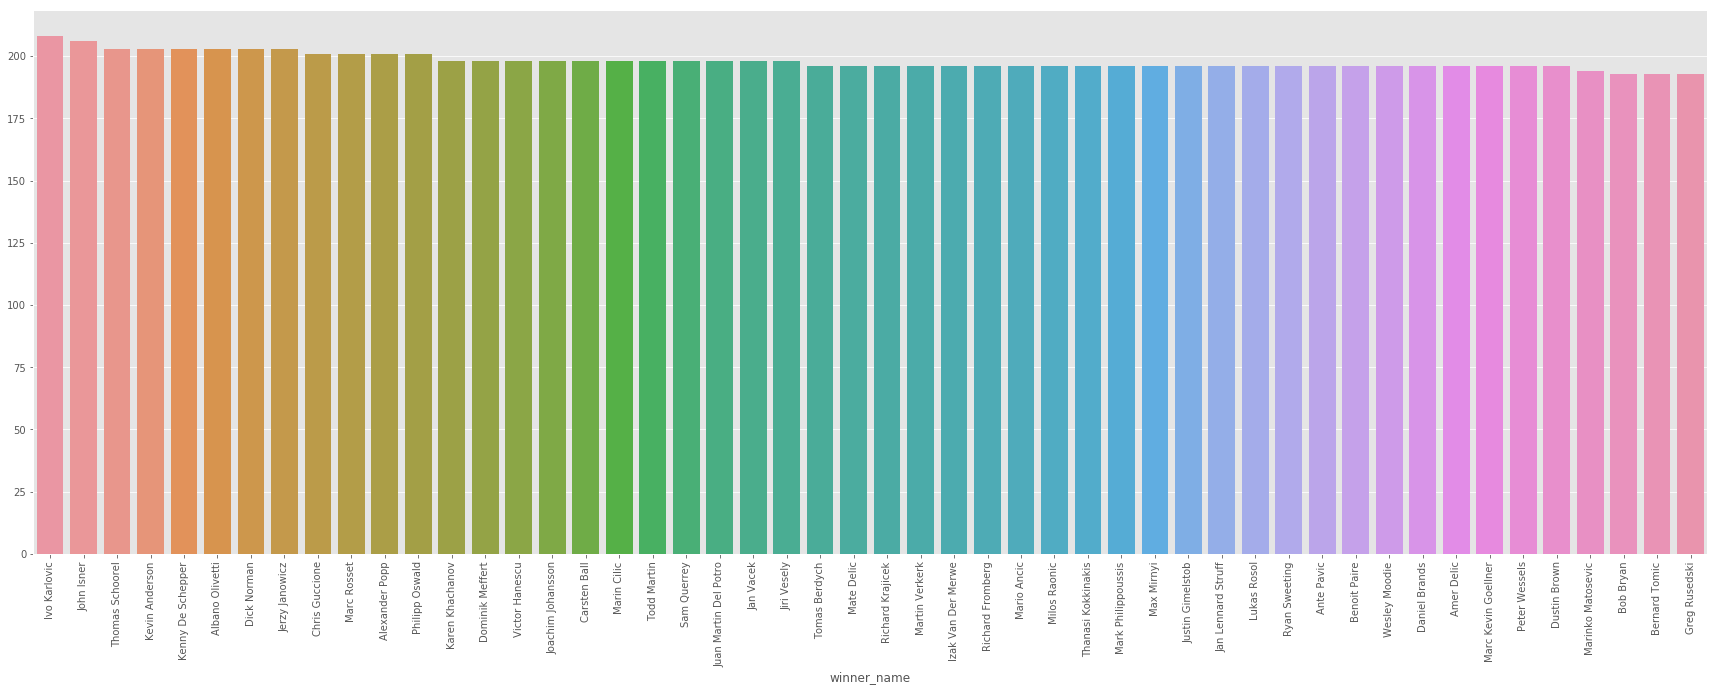

In [25]:
plt.figure(figsize=(30,10))
a=sns.barplot(x=tops.index, y=tops.values)
for item in a.get_xticklabels():
    item.set_rotation(90)

### 6. Average minutes per game:

     Para poder hacer cualquier iteración lo primero que tenemos que hacer es ordenar cronologicamente, ya que la iteración debe buscar la información en partidos pasados, obviando los partidos ocurridos posteriormente.
     
     Basicamente la iteración buscará en cada partido para ambos jugadores los 'minutes' de todos aquellos partidos (aparezca como winner o loser) pasados. Para hacer la media simplemente sumará todos los minutes y lo dividirá por el total de partidos.

In [26]:
framesDCWO2 = framesDCWO2.sort_values(by=['tourney_date', 'match_num'])

    Ahora ya puedo iterar. En este punto existe la dificultadad de que la duracion del partido va a depender del desarrollo del mismo y además del tipo de torneo que se este jugando, existiendo torneros al mejor de 5 sets y torneos al mejor de 3 sets. Evidentemente la diferencia de tiempo entre uno y otro va a ser importante.
    
    Para solucionar este problema, vamos a convertir el tiempo a tiempo por juego (game), dividiento por el total de juegos obtenido anteriormente.

    Vamos a ordenar el data set:

In [27]:
framesDCWO2 = framesDCWO2.set_index('tourney_date','match_num').sort_index()

    Ahora ya podemos empezar a crear nuestras variables, vamos a acumular los minutes, los juegos y hacer la media. Por último me desaré de las columnas que no necesito:

In [28]:
framesDCWO2['w_minutes_cum']=framesDCWO2.groupby('winner_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['w_TotalGames_cum']=framesDCWO2.groupby('winner_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['w_minutes_average'] = framesDCWO2['w_minutes_cum'] / framesDCWO2['w_TotalGames_cum']
columns = ['w_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

     Hago lo mismo con el loser:

In [29]:
framesDCWO2['l_minutes_cum']=framesDCWO2.groupby('loser_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['l_TotalGames_cum']=framesDCWO2.groupby('loser_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['l_minutes_average'] = framesDCWO2['l_minutes_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['l_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 7. Average aces per game

In [30]:
framesDCWO2['w_aces_cum']=framesDCWO2.groupby('winner_name')['w_ace'].transform(pd.Series.cumsum)
framesDCWO2['w_aces_average'] = framesDCWO2['w_aces_cum'] / framesDCWO2['w_TotalGames_cum']
framesDCWO2['l_aces_cum']=framesDCWO2.groupby('loser_name')['l_ace'].transform(pd.Series.cumsum)
framesDCWO2['l_aces_average'] = framesDCWO2['l_aces_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['w_aces_cum', 'l_aces_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 8. Average double foult per match

In [31]:
framesDCWO2['w_df_cum']=framesDCWO2.groupby('winner_name')['w_df'].transform(pd.Series.cumsum)
framesDCWO2['w_df_average'] = framesDCWO2['w_df_cum'] / framesDCWO2['w_TotalGames_cum']
framesDCWO2['l_df_cum']=framesDCWO2.groupby('loser_name')['l_df'].transform(pd.Series.cumsum)
framesDCWO2['l_df_average'] = framesDCWO2['l_df_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['w_df_cum', 'l_df_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 9. % First In (w_1stIn/game)

     Como voy a hacer un ratio, no me interesa saber el numero de partidos. Voy a ir sumando todos los puntos servidos antes de ese partido y todos los 1st in, haciendo el ratio. Si ese ratio se obtuvo en 10 partidos o 1000 no es un factor que vayamos a utilizar.
     
     Tampoco voy a utilizar la ponderacio de partidos a 3 o 5 sets, ya que al ser un ratio el resultado se va a mover siempre en la misma escala, entre 0-1, independientemente de la duración del mismo. Es evidente que si quisieramos ser puristas tendríamos que diferenciarlos porque el rendimiento de un tenista podría variar en los últimos sets por el cansancio o por una estrategia conservadora en los primeos sets.

In [32]:
framesDCWO2['w_1stIn_cum']=framesDCWO2.groupby('winner_name')['w_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['w_SvGames_cum']=framesDCWO2.groupby('winner_name')['w_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['w_1stIn_average'] = framesDCWO2['w_1stIn_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_1stIn_cum']=framesDCWO2.groupby('loser_name')['l_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['l_SvGames_cum']=framesDCWO2.groupby('loser_name')['l_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['l_1stIn_average'] = framesDCWO2['l_1stIn_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_1stIn_cum', 'l_1stIn_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

     De esta forma hacemos un doble estadistico para cadad jugador, uno cuando pierde y otro cuando gana. Conceptualmente hacerlo asi es correcto, porque lo que intentamos es poner etiquetas (ganador/perdedor) sobre los partidos. El mismo jugador tiene unas estadisticas diferentes cuando gana y cuando pierde.

In [33]:
x = framesDCWO2[framesDCWO2['winner_name'] == 'Rafael Nadal']['w_1stIn_average'].mean()
y = framesDCWO2[framesDCWO2['loser_name'] == 'Rafael Nadal']['l_1stIn_average'].mean()
print (x,y)

(4.23555215253495, 4.510577990387127)


### 9. % First Won (w_1stWon/game)

In [34]:
framesDCWO2['w_1stWon_cum']=framesDCWO2.groupby('winner_name')['w_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['w_1stWon_average'] = framesDCWO2['w_1stWon_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_1stWon_cum']=framesDCWO2.groupby('loser_name')['l_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['l_1stWon_average'] = framesDCWO2['l_1stWon_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_1stWon_cum', 'l_1stWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 10. % Second Won (w_2ndWon/game)

In [35]:
framesDCWO2['w_2ndWon_cum']=framesDCWO2.groupby('winner_name')['w_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['w_2ndWon_average'] = framesDCWO2['w_2ndWon_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_2ndWon_cum']=framesDCWO2.groupby('loser_name')['l_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['l_2ndWon_average'] = framesDCWO2['l_2ndWon_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_2ndWon_cum', 'l_2ndWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

### 11 % Break Point Saved (w_bpSaved/w_bpFaced)

In [36]:
framesDCWO2['w_bpSaved_cum']=framesDCWO2.groupby('winner_name')['w_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['w_bpFaced_cum']=framesDCWO2.groupby('winner_name')['w_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['w_bpSaved_average'] = framesDCWO2['w_bpSaved_cum'] / framesDCWO2['w_bpFaced_cum']
framesDCWO2['l_bpSaved_cum']=framesDCWO2.groupby('loser_name')['l_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['l_bpFaced_cum']=framesDCWO2.groupby('loser_name')['l_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['l_bpSaved_average'] = framesDCWO2['l_bpSaved_cum'] / framesDCWO2['l_bpFaced_cum']
columns = ['w_bpSaved_cum','w_bpFaced_cum', 'l_bpSaved_cum', 'l_bpFaced_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

## 3.2. Data Transformation:

#### 1. Creating new Features: Dif

     Tengo listos los estadísticos de cada partido segmentados entre winner y loser. Como comentamos cuando hicimos el estudio inicial del data set, lo que vamos a introducir son las diferencias entre winner/loser para cada feature.
     
     Para poder generar resultados 1 (win) y 0 (lose) tenemos que aplicar las formulas de la siguiente manera:
        1 = w - l
        0 = -w + l
        
     Voy a aplicar cada fórmula a un 50% del dataset. 

In [37]:
framesDCWO2 = framesDCWO2.reset_index()

#### 1.1.1. dif_Minutes

In [38]:
framesDCWO2['dif_Minutes'] = framesDCWO2['w_minutes_average'] - framesDCWO2['l_minutes_average'] 
framesDCWO2.loc[1::2,'dif_Minutes'] = - framesDCWO2['w_minutes_average'] + framesDCWO2['l_minutes_average'] 

#### 1.1.2. dif_Aces

In [39]:
framesDCWO2['dif_Aces'] = framesDCWO2['w_aces_average'] - framesDCWO2['l_aces_average'] 
framesDCWO2.loc[1::2,'dif_Aces'] = - framesDCWO2['w_aces_average'] + framesDCWO2['l_aces_average'] 

#### 1.1.3. dif_Df

In [40]:
framesDCWO2['dif_Df'] = framesDCWO2['w_df_average'] - framesDCWO2['l_df_average'] 
framesDCWO2.loc[1::2,'dif_Df'] = - framesDCWO2['w_df_average'] + framesDCWO2['l_df_average'] 

#### 1.1.4. dif_1stIn

In [41]:
framesDCWO2['dif_1stIn'] = framesDCWO2['w_1stIn_average'] - framesDCWO2['l_1stIn_average'] 
framesDCWO2.loc[1::2,'dif_1stIn'] = - framesDCWO2['w_1stIn_average'] + framesDCWO2['l_1stIn_average'] 

#### 1.1.5. dif_1stWon

In [42]:
framesDCWO2['dif_1stWon'] = framesDCWO2['w_1stWon_average'] - framesDCWO2['l_1stWon_average'] 
framesDCWO2.loc[1::2,'dif_1stWon'] = - framesDCWO2['w_1stWon_average'] + framesDCWO2['l_1stWon_average'] 

#### 1.1.6. dif_2ndWon

In [43]:
framesDCWO2['dif_2ndWon'] = framesDCWO2['w_2ndWon_average'] - framesDCWO2['l_2ndWon_average'] 
framesDCWO2.loc[1::2,'dif_2ndWon'] = - framesDCWO2['w_2ndWon_average'] + framesDCWO2['l_2ndWon_average'] 

#### 1.1.7. dif_BpSv

In [44]:
framesDCWO2['dif_BpSv'] = framesDCWO2['w_bpSaved_average'] - framesDCWO2['l_bpSaved_average'] 
framesDCWO2.loc[1::2,'dif_BpSv'] = - framesDCWO2['w_bpSaved_average'] + framesDCWO2['l_bpSaved_average'] 

Ahora vamos a volver a las primeras variables:

#### 1.1.8. dif_Age

In [45]:
framesDCWO2['dif_Age'] = framesDCWO2['winner_age'] - framesDCWO2['loser_age'] 
framesDCWO2.loc[1::2,'dif_Age'] = - framesDCWO2['winner_age'] + framesDCWO2['loser_age'] 

#### 1.1.9. dif_Height

In [46]:
framesDCWO2['dif_Height'] = framesDCWO2['winner_ht'] - framesDCWO2['loser_ht'] 
framesDCWO2.loc[1::2,'dif_Height'] = - framesDCWO2['winner_ht'] + framesDCWO2['loser_ht'] 

#### 1.1.10. dif_Rank

In [47]:
framesDCWO2['dif_Rank'] = framesDCWO2['winner_rank'] - framesDCWO2['loser_rank'] 
framesDCWO2.loc[1::2,'dif_Rank'] = - framesDCWO2['winner_rank'] + framesDCWO2['loser_rank'] 

#### 1.1.11. dif_RankP

In [48]:
framesDCWO2['dif_RankP'] = framesDCWO2['winner_rank_points'] - framesDCWO2['loser_rank_points'] 
framesDCWO2.loc[1::2,'dif_RankP'] = - framesDCWO2['winner_rank_points'] + framesDCWO2['loser_rank_points'] 

## El otro tipo de estadisticos:
a) Ultimos 5 partidos:

In [49]:
#df["sum4"] = df.groupby("Type")["Value"].apply(lambda x: pd.rolling_sum(x,4))

In [50]:
### Probar doble group by para los últimos 5 partidos

## TARGET:

     Vamos a crear el vector Y siguiendo la lógica aplicada con anterioridad. Las lineas impares contienen victorias (w-l), mientras que las líneas pares contiene derrotas (-w+l). Por tanto, codificaremos como 1 las lineas impares y 0 las lineas pares.

In [51]:
framesDCWO2['Y'] = 1
framesDCWO2.loc[1::2,'Y'] = 0

    Generamos el dataframe definitivo incluyendo todas las features que vamos a utilizar:

In [52]:
TennisDF = framesDCWO2[['Y','dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]             

In [53]:
TennisDF.shape

(42550, 14)

In [54]:
TennisDF.isnull().sum()

Y               0
dif_Rank        0
dif_RankP       0
dif_Height      0
dif_Age         0
w_hand          0
l_hand          0
dif_Minutes     0
dif_Aces        0
dif_Df          0
dif_1stIn       0
dif_1stWon      0
dif_2ndWon      0
dif_BpSv       41
dtype: int64

In [55]:
TennisDF = TennisDF.dropna()

In [56]:
TennisDF.shape

(42509, 14)

In [57]:
TennisDF.isnull().sum()

Y              0
dif_Rank       0
dif_RankP      0
dif_Height     0
dif_Age        0
w_hand         0
l_hand         0
dif_Minutes    0
dif_Aces       0
dif_Df         0
dif_1stIn      0
dif_1stWon     0
dif_2ndWon     0
dif_BpSv       0
dtype: int64

In [58]:
TennisDF.min(), TennisDF.max()

(Y                  0.000000
 dif_Rank       -1507.000000
 dif_RankP     -16092.000000
 dif_Height       -43.000000
 dif_Age          -25.921971
 w_hand             0.000000
 l_hand             0.000000
 dif_Minutes       -4.007906
 dif_Aces          -0.999838
 dif_Df            -0.427169
 dif_1stIn         -3.296887
 dif_1stWon        -2.234244
 dif_2ndWon        -1.589286
 dif_BpSv          -1.000000
 dtype: float64, Y                  1.000000
 dif_Rank        1798.000000
 dif_RankP      16641.000000
 dif_Height        43.000000
 dif_Age           19.468857
 w_hand             1.000000
 l_hand             1.000000
 dif_Minutes       11.441529
 dif_Aces           0.711905
 dif_Df             0.600000
 dif_1stIn          2.953446
 dif_1stWon         2.285714
 dif_2ndWon         1.407463
 dif_BpSv           0.833333
 dtype: float64)

**Antes de seguir vamos a hacer una copia de este DataSet. Esta será nuestra base para todos los trabajos posteriores:**

In [59]:
TennisDF.to_csv('TennisDF', encoding='utf-8', index=False)

## 3.2. Data Transformation:

#### 1. Creating new Features: Sets

In [60]:
# Separo los sets:
#framesDCWO2['s1'], framesDCWO2['s5'] = framesDCWO2['score'].str.split(' ', 1).str
#framesDCWO2['s2'], framesDCWO2['s5'] = framesDCWO2['s5'].str.split(' ', 1).str
#framesDCWO2['s3'], framesDCWO2['s5'] = framesDCWO2['s5'].str.split(' ', 1).str
#framesDCWO2['s4'], framesDCWO2['s5'] = framesDCWO2['s5'].str.split(' ', 1).str
# Separo los juegos:
#framesDCWO2['w_s1'], framesDCWO2['l_s1'] = framesDCWO2['s1'].str.split('-', 1).str
#framesDCWO2['w_s2'], framesDCWO2['l_s2'] = framesDCWO2['s2'].str.split('-', 1).str
#framesDCWO2['w_s3'], framesDCWO2['l_s3'] = framesDCWO2['s3'].str.split('-', 1).str
#framesDCWO2['w_s4'], framesDCWO2['l_s4'] = framesDCWO2['s4'].str.split('-', 1).str
#framesDCWO2['w_s5'], framesDCWO2['l_s5'] = framesDCWO2['s5'].str.split('-', 1).str
# Quito los tiebreaks

#### 2. Eliminating Features:

In [61]:
#el framesDCWO2['s1']
#del framesDCWO2['s2']
#del framesDCWO2['s3']
#del framesDCWO2['s4']
#del framesDCWO2['s5']
# Cuando repase todo hacer reengeniere:
# df.drop(df.columns[[0, 1, 3]], axis=1)

In [62]:
#framesDCWO2.columns

## 3.3. Data Analisis:

### 3.3.1. Feature distribution:

    Vamos a analizar visualmente la distribución de de nuestras variables:

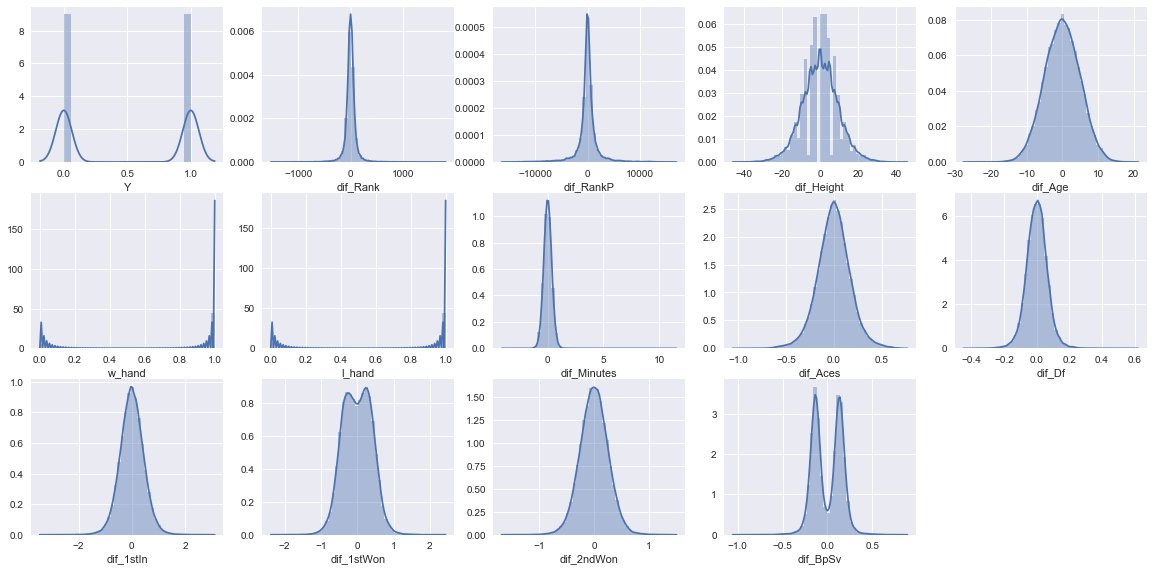

In [63]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
for index,col in enumerate(TennisDF.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDF[col])

     Antes de introducir las variables en el modelo vamos a estandarizarlas:

   **METODO 1:**

     Lo primero que voy a hacer es separar los data sets, en dos, una para los predictores y otro para el target.

In [64]:
TennisDF_X = TennisDF[['dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]
TennisDF_Y = TennisDF['Y']

     Ahora normalizo las variables predictoras:

In [65]:
TennisDFnorm_X = TennisDF_X.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

In [66]:
TennisDFnorm_X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn,dif_1stWon,dif_2ndWon,dif_BpSv
0,-0.429112,0.480356,0.845264,-1.907903,0.368448,-2.576821,-0.004915,1.895517,-1.833948,-0.789742,0.001725,-0.230945,0.181169
1,-0.278954,0.634250,0.738884,-1.603764,-2.714087,0.388075,-0.004915,1.009726,3.755639,-0.275683,0.146904,1.047744,-0.319451
2,1.356094,-0.266931,0.738884,0.043516,0.368448,-2.576821,-0.004915,-0.000907,-4.543214,3.741265,2.965791,-1.636733,2.122969
3,0.054729,-0.055915,-0.537676,0.569459,0.368448,0.388075,-0.004915,-0.587074,-3.116080,-1.792722,-2.792965,1.571545,-1.517906
4,-0.087086,0.036610,0.206984,-1.044215,0.368448,0.388075,-0.004915,-0.000907,-5.840609,0.562962,1.589617,2.455458,2.316045


     Vuelvo a visualizar las variables predictoras para ver si están contenidas entre su media y 3 veces su desviación estandar:

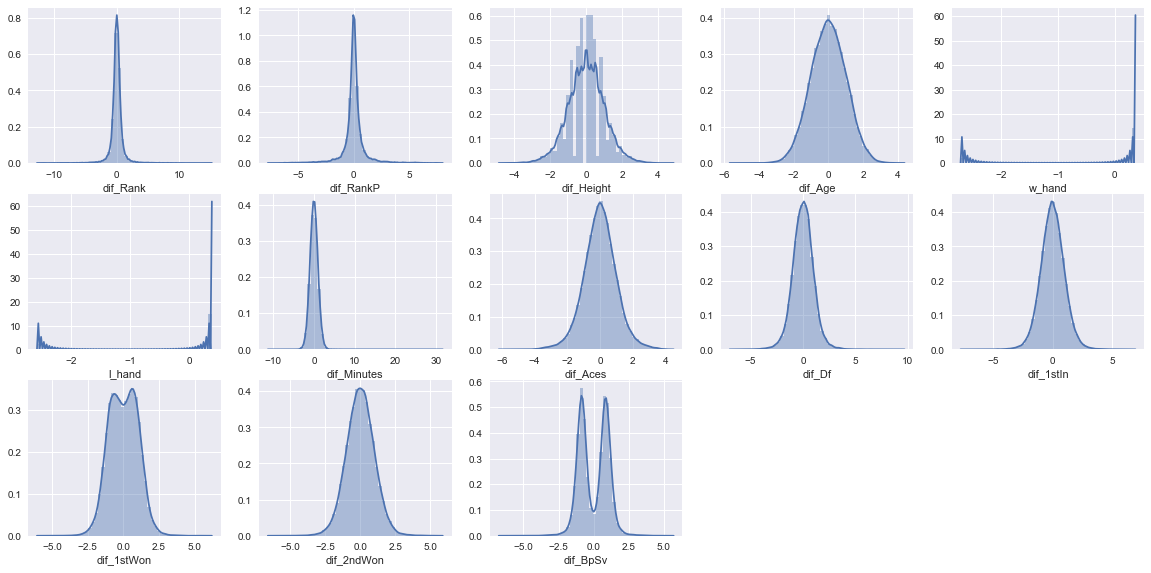

In [67]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
for index,col in enumerate(TennisDFnorm_X.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDFnorm_X[col])

    Parece que la mayor parte de las variables tienen una distribución normal, con una dispersión contenida.

In [68]:
TennisDFnorm_X['dif_Aces'].std(), TennisDFnorm_X['dif_Aces'].median()

(1.000011762422584, 0.0032719733522802398)

In [69]:
TennisDFnorm_X['dif_Age'].std(), TennisDFnorm_X['dif_Age'].median()

(1.0000117624225726, 0.0015081396382973576)

     Si analizamos por ejemplo dif_Aces o Dif_Age podemos comprobar que la mayor parte de los valores se encuentran contenidos en el intervalo que comprende la mediana y 3 veces su desviación.

METODO 2:

In [70]:
#X = (TennisDF[TennisDF.columns[1:13]]).values
#X_norm = preprocessing.scale((TennisDF[TennisDF.columns[1:13]]).values)

In [71]:
#X_norm

In [72]:
#y = TennisDF['Y']

El resultado del metod 1 y 2 coinciden

# 5. Modeling the data:

## 5.1. Base line model:

     Vamos a buscar un escenario base para poder medir los progresos de nuestros modelos. Para este escenario utilizaré dif_Rank, algo que es sencillo de obtener y de interpretar. El indice de acierto debería mejorar el propio azar, aunque con un resultado muy bajo.

In [73]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
X = TennisDFnorm_X[['dif_Rank']]
y = TennisDF['Y']

In [75]:
logreg = linear_model.LogisticRegression()

In [76]:
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
logreg.score(X, y, sample_weight=None)

0.65701380884048088

    Esto no es del todo correcto, debería separar el dataframe en un set para entrenar el modelo y otro para hacer el test. De esta forma obtendremos un modelo más realista.

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X, y)

In [79]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
logreg.score(X_test, y_test, sample_weight=None)

0.65816710575837412

     Vamos a hacer cross validation para ver la varianza en el resultado:

In [81]:
from sklearn.model_selection import cross_val_score

In [82]:
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.65098777,  0.66556914,  0.66980245,  0.63969897,  0.66713748])

In [83]:
np.average(cross_val_score(logreg, X_test, y_test,cv=5))

0.65863916039067916

###       Analisis de la Colinearidad:

     Como advertimos al inicio del proyecto, sabemos por análisis preliminares de la posible existencia de colinearidad en los datos que describen el resultado de los partidos. Vamos a estudiar individualmente todos esos datos, con objeto de conocer su correlación con la variable objetivo y desechar aquellas que estén introduciendo el resultado en las variables predictoras:

    1. First In:

In [84]:
X = TennisDFnorm_X[['dif_1stIn']]

In [85]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.57855127,  0.59266228,  0.54985889,  0.58682353,  0.59294118])

     OK, no existe una correlación importante con el resultado.

    2. Second Won:

In [86]:
X = TennisDFnorm_X[['dif_2ndWon']]

In [87]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.7158984 ,  0.7229539 ,  0.70413923,  0.71401693,  0.70480226])

     Existe una correalción fuerte. Deberíamos rechazarla en el modelo.

    3. First Won:

In [88]:
X = TennisDFnorm_X[['dif_1stWon']]

In [89]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.87582314,  0.86547507,  0.86594544,  0.86729412,  0.86588235])

     Existe una correalción fuerte. Deberíamos rechazarla en el modelo.

    4. Break Points saved:

In [90]:
X = TennisDFnorm_X[['dif_BpSv']]

In [91]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
cross_val_score(logreg, X_test, y_test,cv=5) 

array([ 0.97320169,  0.97036689,  0.97270588,  0.96564706,  0.96941176])

     Esta totalmente correlacionada con el resultado, normalmente gana el partido el que mas veces rompa el servicio a su rival, por tanto este estadístico explica (individualemente) en un 97% de los casos el resultado del partido.
     
     Como habiamos previsto estas dos magnitudes combinan el total de puntos jugados, pasados a la primera, metidos a la primera y segunda. Evidentemente con toda esta información, simplemente sumando, podemos obtener el ganador. Tenemos que quitarlos del data set.

In [92]:
del TennisDFnorm_X['dif_1stWon']
del TennisDFnorm_X['dif_2ndWon']
del TennisDFnorm_X['dif_BpSv']

In [93]:
X = TennisDFnorm_X

In [94]:
X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn
0,-0.429112,0.480356,0.845264,-1.907903,0.368448,-2.576821,-0.004915,1.895517,-1.833948,-0.789742
1,-0.278954,0.634250,0.738884,-1.603764,-2.714087,0.388075,-0.004915,1.009726,3.755639,-0.275683
2,1.356094,-0.266931,0.738884,0.043516,0.368448,-2.576821,-0.004915,-0.000907,-4.543214,3.741265
3,0.054729,-0.055915,-0.537676,0.569459,0.368448,0.388075,-0.004915,-0.587074,-3.116080,-1.792722
4,-0.087086,0.036610,0.206984,-1.044215,0.368448,0.388075,-0.004915,-0.000907,-5.840609,0.562962


Vamos a hacer una copia del dataframe definitivo para poder utilizarlo en otros notebooks del proyecto.

In [95]:
X.to_csv('X', encoding='utf-8', index=False)
y = TennisDF[['Y']]
y.to_csv('y', encoding='utf-8', index=False)

Cuidado! Aqui hacemos un df con Y para que al hacer la copia y utilizar el fichero en otro notebook no utilice la primera fila como titulo de columna. En el resto del notebook y será una lista.

## 5.2. Summarize of the models:

KNIME

## 5.3. Logistic Regresion:

     Como hicimos en el base line, el primer método que vamos a utilizar es el de regresión Logística. El obejtivo es conocer los coeficeintes y la significatividad, y por tanto la importancia, asigandos a cada variable de tal manera que podamos diseñar un modelo que maximice el accuracy y minimice el ruido.

In [96]:
from sklearn import linear_model

In [97]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [98]:
logreg = linear_model.LogisticRegression()

    1. Entrenamos el modelo y sacamos su accuracy:

In [99]:
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [100]:
logreg.score(X, y, sample_weight=None)

0.83911642240466722

     2. A continuación sacamos un resumen del modelo (coeficientes, t, etc.) 

In [101]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     3709.
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:46:09   Log-Likelihood:                -17519.
No. Observations:               42509   AIC:                         3.506e+04
Df Residuals:                   42498   BIC:                         3.515e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4999      0.002    282.073      

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


     Vamos a repasar la importancia de las variables de manera gráfica dibujando los coeficientes. Como sabemos que el std error es muy pequeño, aquellas variables que tengan un coeficiente grande serán más significativas (estadístico t muy pequeño, probabilidad de cumplimiento de la hipótesis nula elevada.

In [102]:
Coef = logreg.coef_

In [103]:
Coef = ([-0.35267597,  0.43801613, -0.75690098, -0.21244024,  0.02075567,
         0.00830926,  0.31282488,  1.96696457, -1.71294075, -0.20619651])

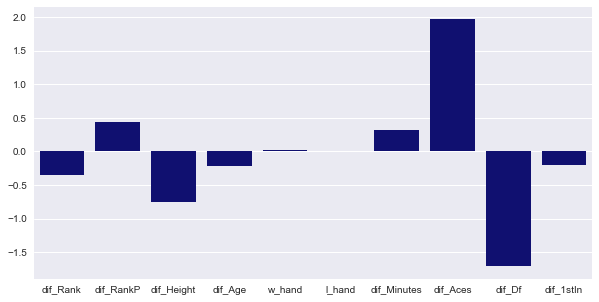

In [104]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.barplot(x=X.columns, y=Coef, color="navy")

     Hay dos variables predictoras que no tienen ninguna influencia sobre el modelo (no son significativas), winner hand y loser hand. Es evidente que ser zurdo o diestro no tiene ninguna influencia en el resultado.

### 5.3.1. Backward Selection:

Las dos variables que mejor definen un modelo de regresión lineal son:
 - r2 : Indica el % de variabilidad explicado por el modelo
 - Residual Standard Error (RSE): Es la medida fundamental de falta de ajuste del modelo.

Cuanto más alta la R2 y más bajo sea el RSE mejor será nuestro modelo.
Conseguimos cambios en estos estadísticos introduciendo o sacando variables de nuestro modelo. Hay dos maneras fundamentales de hacerlo:
 - Forward selection: Metemos una sola variable (la más significativa. Mirar matriz de correlación) y posteriormente vamos añadiendo el resto de una en una. Añadiremos aquellas que mejoren el R2 significativamente y no aumenten significativamente el RSE.
 - Backward selection: HAcemos el proceso inverso, metemos en el modelo todas las variables y vamos descartando aquellas que no aporten inforación, es decir R2, y minimicen el RSE.

 Hemos elegido este segundo método.

#### Vamos a calcular el MSE:

In [105]:
#Prediction = 0.4999 - 0.0315*X['dif_Rank'] + 0.0612*X['dif_RankP'] - 0.0966*X['dif_Height'] - 0.0296*X['dif_Age']
+ 0.0031*X['w_hand'] + 0.006*X['l_hand'] + 0.0418*X['dif_Minutes'] + 0.2479*X['dif_Aces'] - 0.2089*X['dif_Df']
- 0.0332*X['dif_1stIn']

0        0.026219
1        0.009153
2       -0.124210
3        0.059518
4       -0.018690
5        0.047330
7       -0.005345
8       -0.092697
9       -0.014966
10       0.026219
11       0.096761
12       0.104209
13       0.115796
14       0.123244
15      -0.077347
16      -0.017667
18       0.009241
19       0.037528
20      -0.043884
21       0.029725
22       0.101501
23       0.007188
24      -0.010000
25      -0.084485
26       0.158210
27      -0.092643
28       0.011635
29      -0.000069
31      -0.107294
32      -0.029804
           ...   
42520    0.022067
42521   -0.044323
42522   -0.001305
42523   -0.004183
42524    0.013192
42525   -0.014442
42526    0.019350
42527   -0.028556
42528   -0.034955
42529   -0.031174
42530    0.001014
42531   -0.003593
42532    0.020612
42533    0.031215
42534    0.053976
42535    0.046467
42536    0.058800
42537   -0.003783
42538   -0.011150
42539    0.006246
42540   -0.003080
42541   -0.044632
42542   -0.004639
42543    0.003977
42544   -0

In [106]:
#RSEd = (y - Prediction)**2

In [107]:
#RSEdsum = RSEd.sum()

In [108]:
#RSE = np.sqrt(RSEdsum/(42509-10))

In [109]:
#RSE

In [110]:
#yMean = y.mean()

In [111]:
#yMean

In [112]:
#Error = RSE / yMean

In [113]:
#Error

In [114]:
#### TERMINAR

In [115]:
#### Otro metodo:

In [116]:
#from sklearn.metrics import mean_squared_error
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [117]:
#Prediction = logreg.predict(X_test)

In [118]:
#mse = mean_squared_error(y_test, Prediction)

In [119]:
#mse

In [120]:
#from math import sqrt
#rmse = sqrt(mean_squared_error(y_test, Prediction))

In [121]:
#rmse

In [122]:
#### Tiene buena pinta

#### Eliminamos variables:

     Vamos a quitar del modelo las variables w_hand y l_hand, ya que no son significativas y por tanto no aportan a mejorar la reducción de la variabilidad y crean ruido en nuestro modelo. Para facilitar el trabajo posterior voy a crear un nuevo data set sin estos dos valores:

In [123]:
X.columns

Index([u'dif_Rank', u'dif_RankP', u'dif_Height', u'dif_Age', u'w_hand',
       u'l_hand', u'dif_Minutes', u'dif_Aces', u'dif_Df', u'dif_1stIn'],
      dtype='object')

In [124]:
X_BackW = TennisDFnorm_X[['dif_Rank', 'dif_RankP', 'dif_Height', 'dif_Age', 'dif_Minutes', 
                      'dif_Aces', 'dif_Df', 'dif_1stIn']]

In [125]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_BackW, y)
logreg.score(X_BackW, y, sample_weight=None)

0.83885765367333975

     El accuracy mantiene totalmente constante ya que esas variables no aportaban nada, sin embargo, se debería reducir el ruido del modelo, los cual se debería reflejar en una disminución del RSE.

In [126]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_BackW)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     4635.
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:46:11   Log-Likelihood:                -17520.
No. Observations:               42509   AIC:                         3.506e+04
Df Residuals:                   42500   BIC:                         3.514e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4999      0.002    282.069      

#### Vamos a ver com ha variado el RSE:
Para ello cambiamos prediction para quitar los predictores que no están y cambiar los coeficientes del resto.

In [127]:
#Prediction = 0.4999 - 0.0315*X_8['dif_Rank'] + 0.0612*X_8['dif_RankP'] - 0.0966*X_8['dif_Height'] - 0.0296*X_8['dif_Age']
#+ 0.0418*X_8['dif_Minutes'] + 0.2479*X_8['dif_Aces'] - 0.2089*X_8['dif_Df'] - 0.0332*X_8['dif_1stIn']

NameError: name 'X_8' is not defined

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_8, y, random_state=42)

In [ ]:
#Prediction = logreg.predict(X_test)

In [ ]:
#mse = mean_squared_error(y_test, Prediction)

In [ ]:
#mse

In [ ]:
### Cuidado sale lo mismo que antes, haciendolo por los dos metodos

El F-statistic mejora sensiblemente.

### 5.3.2. Correlation matrix:

**Visualizacion 1:**

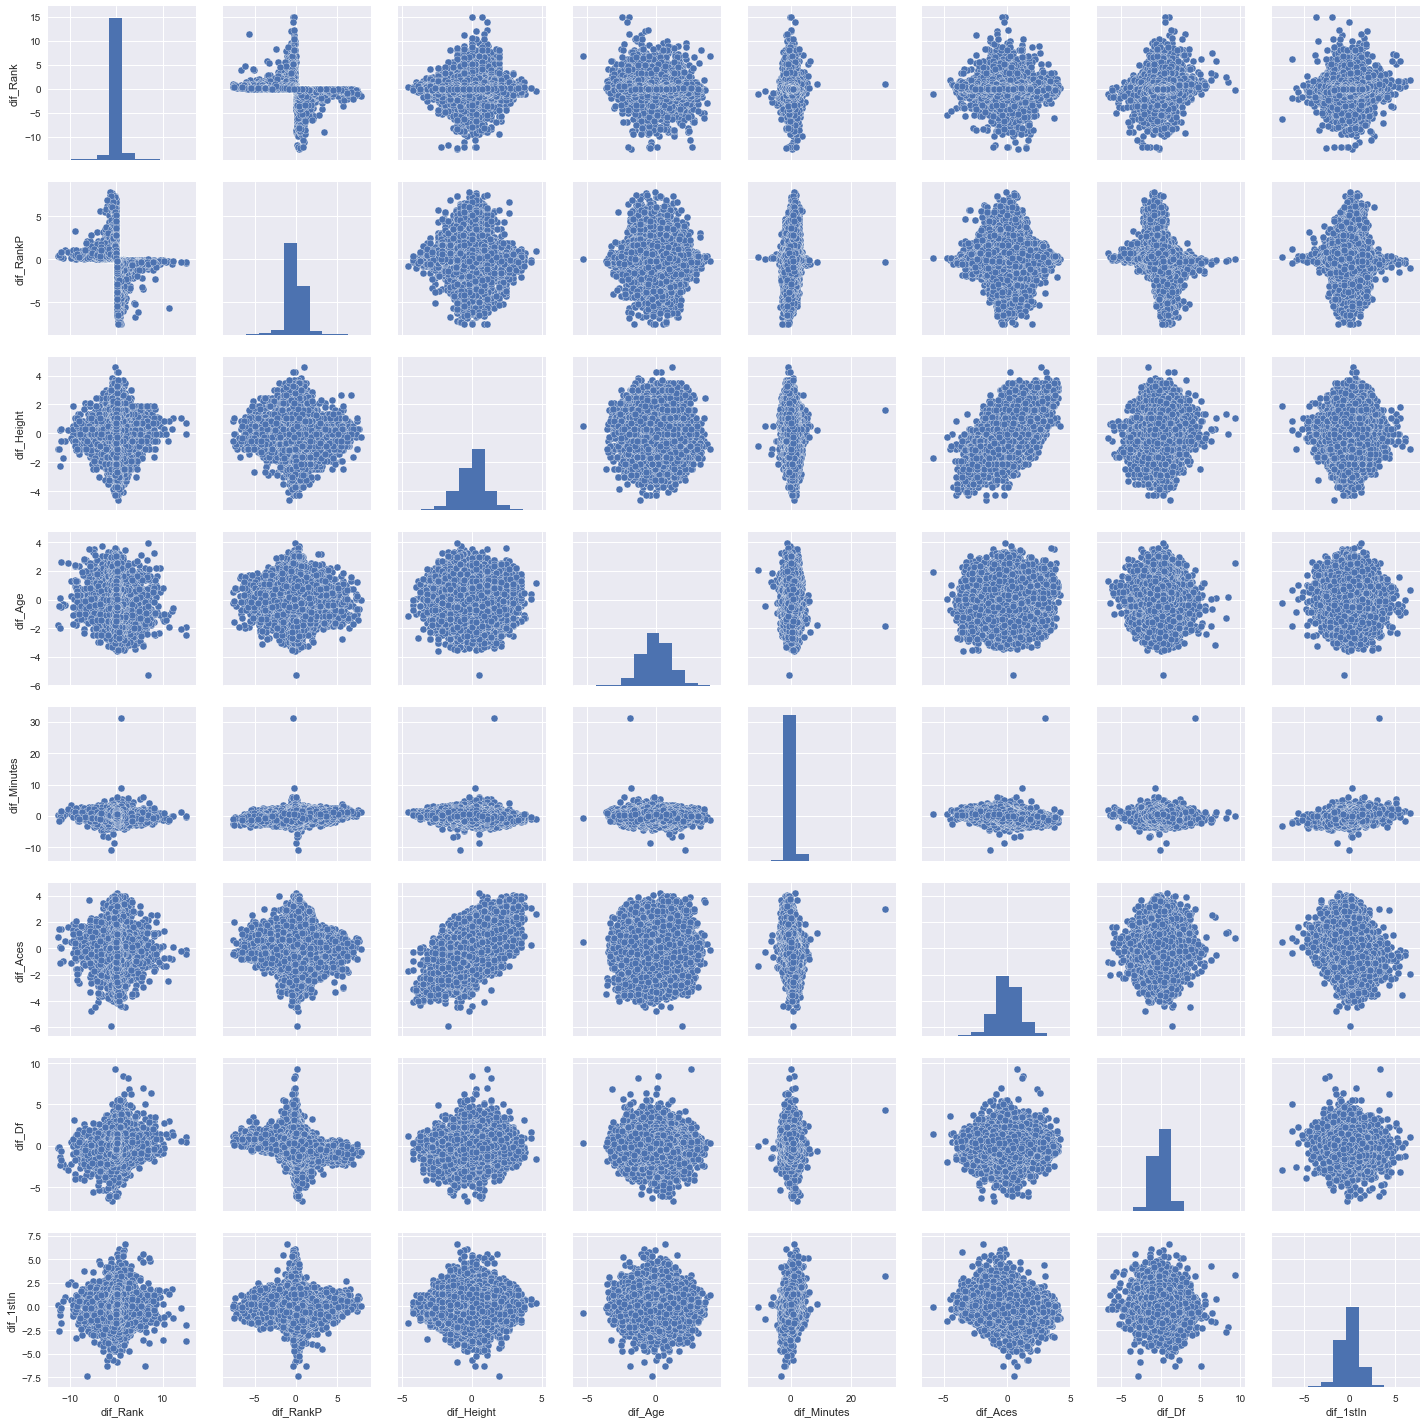

In [128]:
plt.figure(figsize=(20,20))
sns.pairplot(X_BackW)
plt.show()

     La relación más fuerte entre variables parece que existe entre el número de Aces y la altura del jugador, lo cual parece evidente. Con double faults existe correlación aunque es de menor intensidad

**Visualizacion 2:**

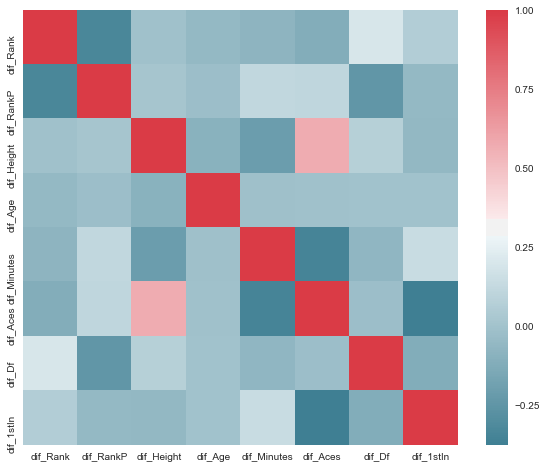

In [129]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_BackW.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Otra manera de visualizarlo:

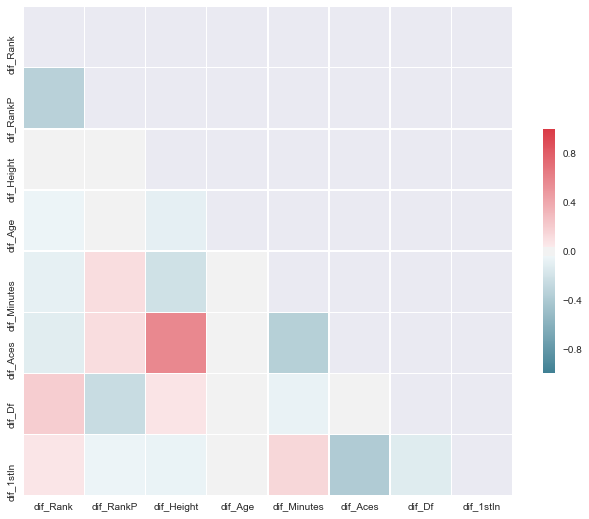

In [130]:
corr = X_BackW.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

     Gracias a esta matriz podemos ver ademas que también existe una realación fuerte entre el numero de double faults y el puesto en el Rank o las Rank poitns, cuanto mas alto es tu numero de Rank mayor la diferencia en el índice de double faults.
     
      Existen otras relaciones interesantes como que cuanto es la diferencia en numero de Aces, menor es la diferencia en duración del partido.

In [131]:
hwin = framesDCWO2['winner_ht'].mean()
hlos = framesDCWO2['loser_ht'].mean()
print hwin
print hlos

185.69106933
185.194876616


In [132]:
hwin_over100 = framesDCWO2[framesDCWO2['winner_rank'] > 50]
hwin_over100 = hwin_over100['winner_ht'].mean()
hwin_in100 = framesDCWO2[framesDCWO2['winner_rank'] < 50]
hwin_in100 = hwin_in100['winner_ht'].mean()
print hwin_over100
print hwin_in100

185.128737589
186.101088016


     La altura media en los ganadaores es mayor que en los perdedores, este hecho se acentúa si filtramos la información entre los situados en las 50 primeras posiciones del ranking mundial y el resto.

### 5.3.3. Reducción dimensionalidad:

 En este modelo el numero de variables es pequeño por lo que podríamos hacer la selección de variables (backward o forward) de manera manual facilmente. Sin embargo si el modelo fuera más extenso en terminos de predictores, esta tarea se volvería mucho más compleja y lenta. Actualmente no existe ningún paquete con algoritmos para hacer estos dos procesos, por ello vamos a utilizar la Regresión de Lasso (least absolute shrinkage and selection operator). Este metodo es un metodo de regresión que realiza selección de variable y regulariza para mejorar la precisión del modelo y simplificarlo para su comprensión.
 
 Hemos elegido Lasso porque al igual que la regresión logística utiliza el algoritmo linear model de sklearn.

In [133]:
### METODO 1:

In [134]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(X, y)

In [ ]:
log.score(log.predict(X),y)

In [ ]:
X.head()

In [ ]:
### METODO 2:

In [ ]:
clf = linear_model.Lasso()

In [ ]:
clf.fit(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(y_test,clf.predict(X_test))

In [ ]:
### METODO 3:

In [ ]:
clf = linear_model.Lasso()

In [ ]:
clf.fit(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
## Acuracy es una medida de clasificacion no de regresion, por tanto no se puede utilizar con lasso

In [ ]:
scores = cross_val_score(clf, X_train, y_train,scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)

In [ ]:
scores

In [ ]:
rmse_scores

In [ ]:
#### REPASAR 

## 5.4.1. KNNeighbours:

      El siguiente modelo que utilizaremos será el K vecinos, el cual trataremos de optimizar a través del número de vecinos (k)

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [136]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [137]:
clf = KNeighborsClassifier(n_neighbors = 5)

     Vamos a separa ed data set en train-test:

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

     Por defecto el sistema separa en 75% train 25% test:

In [139]:
len(X_train)

31881

In [140]:
len(X_test)

10628

In [141]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### a) Vamos a valorar el ajuste del modelo:

In [142]:
accuracy_score(clf.predict(X_test), y_test)

0.8295069627399323

In [143]:
cvs_Knn = cross_val_score(clf,X,y,cv=10)
cvs_Knn

array([ 0.74106303,  0.7953904 ,  0.81157375,  0.84497765,  0.83368619,
        0.84733004,  0.8398024 ,  0.83623529,  0.84070588,  0.83482353])

In [144]:
np.average(cross_val_score(clf, X, y, cv=10))

0.82255881701416611

    El accuracy es muy similar al de la regresión lineal.

#### b) Vamos a averiguar el número óptimo de K:

In [145]:
scores=[]
for i in range(1,25):
    clf = KNeighborsClassifier(n_neighbors=i)
    scores.append(cross_val_score(clf,X,y,cv=4))

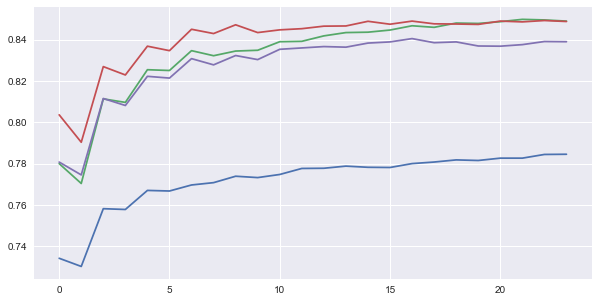

In [146]:
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.show()

     La mejora del accuracy es sustancial de 1 a 5. De 5 a 10 mejora en menor medida y apartir de aqui no se produce ninguna mejora más. El cálculo es muy lento, por lo que cuantos menos kneighbours utilicemos más rebajaremos el tiempo de proceso. El númer optimo se sitúa en el entorno de los 5 kneigbours.

## 5.4.2. SVM:

In [147]:
from sklearn.svm import SVC

In [148]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [149]:
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

     Como sospechamos que el modelo no es lineal vamos a cambiara el kernel a rbf, para que el algoritmo se ajuste mejor al modelo:

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [151]:
accuracy_score(y_test,clf.predict(X_test))

0.84898381633421149

In [152]:
cross_val_score(clf,X,y,cv=5)

array([ 0.78831001,  0.84852405,  0.86307493,  0.85437007,  0.86025174])

     Vamos a completar el analisis del resultado: Vamos a mostrar la matriz de confusion y a mostrar el indice de

**Precision** = True Positives / True Positives + False Positives

**Recall** = True positives / True Positives + False Negatives

In [153]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [154]:
mat = confusion_matrix(y_test,clf.predict(X_test))
dfmat = pd.DataFrame(mat,index = ["Win","Lose"],
                  columns = ["Win","Lose"])

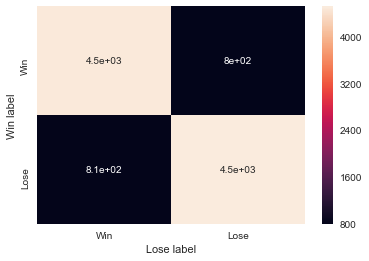

In [155]:
sns.heatmap(dfmat,annot=True)
plt.ylabel('Win label')
plt.xlabel('Lose label')
plt.show()

In [156]:
dfmat.describe

<bound method DataFrame.describe of        Win  Lose
Win   4503   795
Lose   810  4520>

In [157]:
Precision = float(dfmat.iloc[0,0]) / (float(dfmat.iloc[0,0] + dfmat.iloc[0,1]))
Precision
Recall = float(dfmat.iloc[0,0]) / (float(dfmat.iloc[0,0] + dfmat.iloc[1,0]))
Recall
print """    De los partidos que hemos clasificados como ganadores, el %f tuvieron ese resultado. En total clasificamos 
correctamente el %f, de todos los partidos con categoría ganador. """ %(Precision, Recall)


    De los partidos que hemos clasificados como ganadores, el 0.849943 tuvieron ese resultado. En total clasificamos 
correctamente el 0.847544, de todos los partidos con categoría ganador. 


In [158]:
F1score = (2*float(dfmat.iloc[0,0]))/((2*float(dfmat.iloc[0,0])+float(dfmat.iloc[0,1])+float(dfmat.iloc[1,0])))
F1score

0.848741871642635

    Este sería el punto óptimo de la curva precisión-recall. El F1 score, coincide practicamente con el accuracy score obtenido anteriormente.

**Vamos a dibujar la precision-recall curve:**

In [159]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

In [160]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

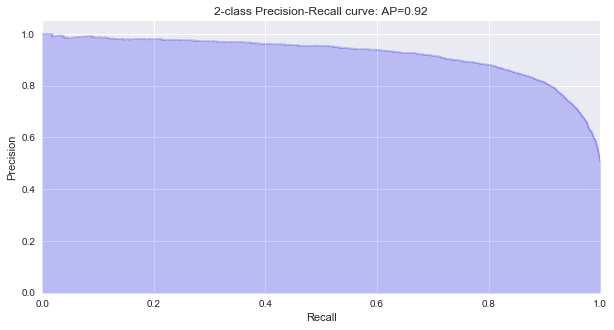

In [162]:
plt.figure(figsize=(10,5))
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

     Como vimos con anterioridad, el punto de la curva 0.849 , 0.847 que arroja el modelo como óptimo corresponde al vértice de la curva.

#### Vamos a dibujar la curva ROC:

In [173]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

n_classes = y.shape[1]

random_state = np.random.RandomState(0)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


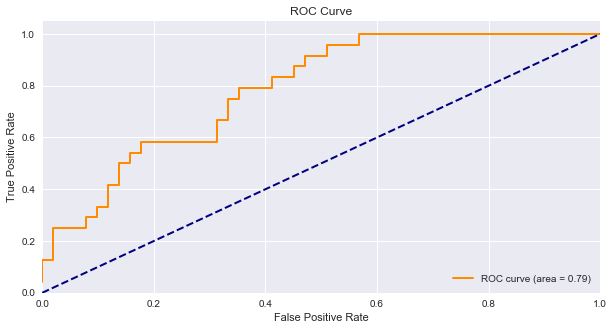

In [174]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Space')
plt.legend(loc="lower right")
plt.show()

         La linea azul es AUC=1 o valor de diagnostico perfecto, mientras que la linea amarilla es AUC=0.79 o el diagnostico del modelo de test. Un diagnostico superior al 0.75 se puede considerar bueno. Un diganostico del 0.79 significa que hay un 79% más de probabilidades de que nuestra clasificación sea correcta que si hicieramos una elección al azar.

## 5.5. Naive Bayes Classifier:

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [ ]:
gnb = GaussianNB()

In [ ]:
y_pred = gnb.fit(X, y).predict(X)

In [ ]:
print("Number of mislabeled points out of a total %d points : %d"
...       % (X.shape[0],(y != y_pred).sum()))

## 5.6. Neuronal Network:

In [ ]:
cd ..

In [ ]:
import tensorflow as tf

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

## 5.7. Decision Tree:

In [ ]:
from sklearn import tree

In [ ]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf.fit(X_train,y_train)

In [ ]:
accuracy_score(y_test,clf.predict(X_test))

In [ ]:
cross_val_score(clf,X,y,cv=5)

In [ ]:
np.average(cross_val_score(clf,X,y,cv=5))

#### El resultado obtenido es mucho peor que con cualquiera de los otros clasificadores:

    Vamos a intentar dibujar el árbol resultante y analizarlo:

In [ ]:
import pydotplus
%matplotlib inline
from IPython.display import Image

In [ ]:
colnames = X.columns

In [ ]:
dot_data=tree.export_graphviz(clf, out_file=None, feature_names=['dif_Rank', 'dif_RankP', 'dif_Height', 'dif_Age', 'w_hand',
       'l_hand', 'dif_Minutes', 'dif_Aces', 'dif_Df', 'dif_1stIn'], filled=True)

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data)

In [ ]:
Image(graph.create_png())

#### Interpretación:

El objetivo de un modelo **Decision Tree** es preveer el valor destino (y) en función de diversas variables de entrada (X). Metricas:
* **Gini** (grado de impureza)
* **Entropia** o ganancia de información (información asociada a la distribución de probabilidades)

En este caso hemos elegido utilizar Gini como medida.

El modelo busca ir creando nodos hijos con un nivel de pureza mejor (menor Gini). Por ello empieza con variable que el modelo estima es la que menos información aporta, en este caso ** *df_minutes* **. Y continua creando los siguientes con varibales que con poca información,** *l_hand, w_hand. * ** Recordemos que estas dos variables son las que sacamos del modelo, porque no aportaban información y contribuían a incrementar el RSE. 
Los nodos finales de nuestro árbol, por tanto, estarán formados por las variables que aporten mayor información individualmente (* **df_Aces** * por ejemplo) o en conjunto con las otras.

In [ ]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation as cv
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn import preprocessing
from scipy.stats import randint as sp_randint

A cotincuación, com hemos hecho en otros modelos, vamos a intentar optimizar este clasificador a travès de alguna de sus características. Las más fácil de comprender es la Profundidad del árbol. ¿Hasta que punto es interesante incrementarla?

**Profundidad del Árbol:**

In [ ]:
plt.figure(figsize=(10,5))
feature_param = range(1,50)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Maxima Profundidad')
plt.grid();

El ajuste de este algoritmo mejora hasta los 8 niveles de profundidad en los que alcanza su máxima

## 6. Cross Validation:

### 6.1. Cross Validation:

### 6.2. Bagging:

Como pudimos ver con anterioridad, al dividir un data set aleatoriamente en varios set de train, el resultado puede ser sensiblemente difente al aplicar el modelo en el set de test. La varianza puede ser elevada

Para evitar este problema:
Bootstrap aggregarion o Bagging son metodos dirigidos a reducir la varianza en un modelo. Como no disponemos de varios set de train lo que haremos es hacer distintos sets del original train set y hacer una media de los distintos accuracies sobre el data set de test.

Bagging es muy util, especialmente para decision trees, ya que cada arbol individualmente tienen un sesgo pequeño pero una varianza alta. La regresión logística, por el contrario, tiene una varianza pequeña pero podría tener un sesgo importante por lo que no es interesante hacer bagging.

En el caso del Bagging utilizaremos el Out-of-Bag score para medir su accuracy.

El problema del bagging es que al ser una combinación de muchos árboles, no vamos a poder dibujara nuestro arborl de decisión ni tampoco saber la importancia de las variables.


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
X = TennisDFnorm_X
y = TennisDF['Y']

**a) Hacemos Bagging con Decision Tree:**

In [ ]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),oob_score=True)
clf.fit(X,y)

In [ ]:
accuracy = clf.oob_score_
print("Accuracy: %.2f%%" % (accuracy * 100.0))

No hemos obtenido una mejora sobre el resultado obtenido con el set de train-test

**b) Hacemos el Bagging con SVM** (que es el algoritmo que mejor resultado nos ha dado):

In [ ]:
clf = BaggingClassifier(base_estimator=SVC(kernel='rbf'),oob_score=True)
clf.fit(X,y)

In [ ]:
accuracy = clf.oob_score_
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Tampoco obtenemos ningna mejora sobre el calculo en las muestras de train-test

### 6.3. Random Forest:

El random forest funciona de una manera similar al bagging, pero con la diferencia de que limita el numero de predictores que mete en cada árbol. De esta forma se evita construir muchos árboles con los predictores con más entropía en la parte superior del árbol, lo que produciría que la mayor parte de los árboles fueran iguales.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [ ]:
clf = RandomForestClassifier(max_depth=3,oob_score=True)
clf.fit(X, y)

In [ ]:
accuracy = clf.oob_score_
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
clf.feature_importances_

**Guardo la matriz de impotancia para utilizarla posteriormente:**

In [ ]:
FI_RandomF = clf.feature_importances_

Visualizamos la matriz de importancia de las variables predictoras:

In [ ]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.barplot(x=X.columns, y=clf.feature_importances_, color="navy")

Como hemos hecho en otros modelos, vamos a intentar optimizar este clasificador a travès de alguna de sus características. En este caso vamos a determinar el número de estimadores óptimo.

**Número de Estimadores y Máxima Profundidad:**

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
feature_param = range(1,50)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Numero de Estimadores')
plt.grid();


plt.subplot(2,2,2)
feature_param = range(1,50)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Maxima Profundidad')
plt.grid();

#### Interpretación del modelo:

### 6.4. Boosting:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
X = TennisDFnorm_X
y = TennisDF['Y']

In [ ]:
clf = XGBClassifier()

In [ ]:
clf.fit(X,y)

In [ ]:
cross_val_score(clf, X, y, cv=5)

In [ ]:
np.average(cross_val_score(clf, X, y, cv=30))

In [ ]:
clf.feature_importances_

In [ ]:
FI_Boosting = clf.feature_importances_

#### Visualización 1:

In [ ]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.barplot(x=X.columns, y=clf.feature_importances_, color="navy")

Ahora voy a guardar una copia del modelo creado 

#### Visualización 2:

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go

In [ ]:
py.init_notebook_mode()

In [ ]:
py.iplot([go.Scatter(x=X.columns, y=clf.feature_importances_)])

#### Interpretación:

In [ ]:
print """Las variables predictoras con un mayor peso en el modelo son: 

   - dif_Aces: %f 
   - dif_Df: %f 
   - dif_Height: %f"""%(clf.feature_importances_[2],clf.feature_importances_[5],clf.feature_importances_[6])

Esta interpretación es muy similar la obtenida en la regresión lineal:
    - dif_Df
    - dif_Aces
    - dif_Height

## 7. Combining models:

### 7.1. Voting Classifier:

Combinar modelos a veces puede mejorar el accuracy de cualquiera de ellos por separado. El algoritmo que vamos a crear clasifica el evento, teniendo en cuenta el resultado obtenido por otros algoritomos previamente. Puede elegir la clasificación que salga en la mayoría (voting = hard) o hacer una media de los resultados de estos (voting = soft).

Como los resultados de nuestros algoritmos son muy similares, utilizar el método soft no nos va a cambiar sustancialemente el accuravy. Vamos a probar con la mayoría para contrastar si hubiera diferencias sustanciales.

In [ ]:
clf1= linear_model.LogisticRegression()
clf2= SVC(kernel = 'rbf')
clf3= XGBClassifier()

Ahora vamos a ver la correlación entre los clasdificadores combinados. Vamos a utilizar para ello la correlación de Spearman, que tiene algunas ventajas sobre la correlación de Pearson y se encuentra menos restringido a descubrir sólo una asociación lineal entre las variables. 

In [ ]:
from scipy import stats
mat = []
estimators=[('LM', clf1), ('SVC', clf2), ('XGBC', clf3)]
for estimator in estimators:
    estimator[1].fit(X_train,y_train)
for i in range(len(estimators)):
    temp = []
    for j in range(len(estimators)):
        temp.append(stats.spearmanr(estimators[i][1].predict(X_test),estimators[j][1].predict(X_test)).correlation)
    mat.append(temp)

In [ ]:
dfmat = pd.DataFrame(mat,index = ['LM','SVM','XGBC'],
                  columns = ['LM','SVM','XGBC'])

In [ ]:
sns.heatmap(dfmat,annot=True, cmap = 'Blues')
plt.xlabel('Estimators')
plt.show()

La correlación entre los clasificadores es muy elevada, practicamente total.

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
estimators

In [ ]:
clf = VotingClassifier(estimators=estimators)

In [ ]:
clf.fit(X,y)

In [ ]:
np.average(cross_val_score(clf, X, y, cv=10))

El resultado es evidente, si la correlación es tan alta, los resultados obtenidos para cada partido serán prácticamente iguales para los tres, no mejorando por tanto el accuracy de nuestro modelo.

## 8. Conclusiones:

In [ ]:
#### Juntar en el mismo grafico Feature Importance de:
# - Random Tree
# - Boosting
# 

In [ ]:
FI_RandomF = clf.feature_importances_
FI_Boosting = clf.feature_importances_
X.columns

In [ ]:
Comparative = pd.DataFrame()
Comparative['Features'] = X.columns
Comparative['FI_Random'] = FI_RandomF
Comparative['FI_Boosting'] =FI_Boosting

In [ ]:
Comparative.head()

In [ ]:
df = pd.melt(Comparative, id_vars="Features", var_name="Model", value_name="Importance")

In [ ]:
sns.factorplot(x='Features', y='Importance', hue='Model', data=df, kind='bar', size=(7), aspect=(2))
plt.show()